In [55]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.utils import image_dataset_from_directory
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [56]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [57]:
# data pipeline
data = image_dataset_from_directory('data', image_size=(224, 224))

Found 1536 files belonging to 3 classes.


In [58]:
# get a single batch (32 images) within pipeline
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [59]:
# image shape
print(batch[0].shape)
# y values
print(batch[1])

(32, 224, 224, 3)
[2 2 0 0 2 1 1 0 0 0 1 1 2 1 0 0 2 0 0 1 1 1 0 0 2 1 2 2 0 1 0 0]


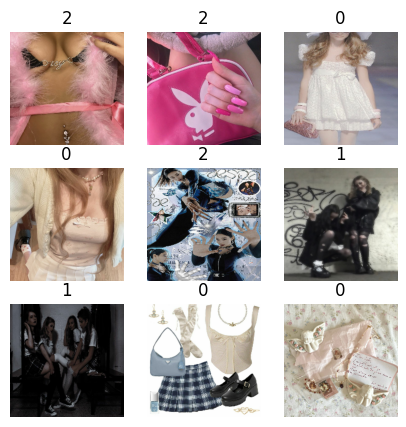

In [60]:
# 0 : coquette :: 1 : grunge :: 2 : y2k
fig, ax = plt.subplots(3, 3, figsize = (5, 5))
for i in range(3):
  for j in range(3):
    ax[i, j].imshow(batch[0][i * 3 + j].astype(int))
    ax[i, j].title.set_text(batch[1][i * 3 + j])
    ax[i, j].axis('off')
plt.show()

In [61]:
# scale data to between 0 and 1 for rgb values instead of 0 to 255
data = data.map(lambda x, y: (x/255, y))
data = data.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

In [62]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
for i in range(5):
    print(batch[1][i])

[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]


/Users/ashley/miniforge3/envs/cv/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


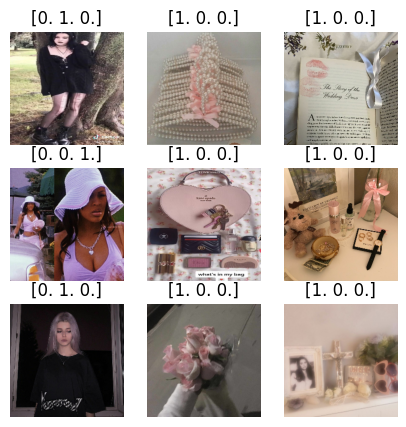

In [63]:
# since rgb values are now between 0 and 1, don't cast to int
# [1, 0, 0] : coquette :: [0, 1, 0] : grunge :: [0, 0, 1] : y2k
fig, ax = plt.subplots(3, 3, figsize = (5, 5))
for i in range(3):
  for j in range(3):
    ax[i, j].imshow(batch[0][i * 3 + j])
    ax[i, j].title.set_text(batch[1][i * 3 + j])
    ax[i, j].axis('off')
plt.show()

In [ ]:
num_batches = len(data)
train_size = int((num_batches) * .8)
val_size = int((num_batches) * .1)
test_size = int((num_batches) * .1)
print(str(train_size) + " " + str(val_size) + " " + str(test_size))

38 4 4


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
vgg = VGG19(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(3, activation='softmax')(x)

In [ ]:
model = Model(inputs = vgg.input, outputs = prediction)
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
  metrics=['categorical_accuracy']
)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor = 'val_loss', patience = 4)

In [ ]:
checkpoint = ModelCheckpoint(filepath='weights.{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss',
                             verbose=1,
                             save_weights_only=True,
                             period=3)

In [ ]:
results = model.fit(train,
                    validation_data = val,
                    epochs = 30,
                    callbacks = checkpoint,
                    batch_size = 32, shuffle = True)

Epoch 1/30
38/38 [==============================] - 45s 991ms/step - loss: 0.9085 - categorical_accuracy: 0.6094 - val_loss: 0.6052 - val_categorical_accuracy: 0.7422
Epoch 2/30
38/38 [==============================] - 42s 1s/step - loss: 0.3536 - categorical_accuracy: 0.8717 - val_loss: 0.6030 - val_categorical_accuracy: 0.7266
Epoch 3/30
38/38 [==============================] - ETA: 0s - loss: 0.2021 - categorical_accuracy: 0.9564
Epoch 3: saving model to weights.03-0.37.h5
38/38 [==============================] - 41s 990ms/step - loss: 0.2021 - categorical_accuracy: 0.9564 - val_loss: 0.3733 - val_categorical_accuracy: 0.8672
Epoch 4/30
38/38 [==============================] - 38s 961ms/step - loss: 0.1712 - categorical_accuracy: 0.9613 - val_loss: 0.5948 - val_categorical_accuracy: 0.7891
Epoch 5/30
38/38 [==============================] - 38s 970ms/step - loss: 0.1437 - categorical_accuracy: 0.9597 - val_loss: 0.5605 - val_categorical_accuracy: 0.8047
Epoch 6/30
38/38 [===========

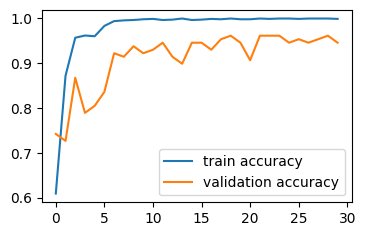

In [ ]:
plt.figure(figsize=(4, 2.5))
plt.plot(results.history['categorical_accuracy'], label = 'train accuracy')
plt.plot(results.history['val_categorical_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

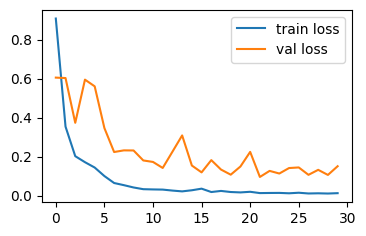

In [ ]:
plt.figure(figsize=(4, 2.5))
plt.plot(results.history['loss'], label = 'train loss')
plt.plot(results.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test, batch_size = 32)

4/4 [==============================] - 7s 698ms/step - loss: 0.1217 - categorical_accuracy: 0.9609


[0.12174814939498901, 0.9609375]

In [ ]:
y_true, y_pred, x_wrong, actual, y_wrong = [], [], [], [], []
for x, y in test:
  true = tf.argmax(y, axis = 1)
  pred = tf.argmax(model.predict(x), axis = 1)
  for i in range (len(np.array(true))):
    if np.array(true)[i] != np.array(pred)[i]:
      x_wrong.append(np.array(x[i]))
      actual.append(np.array(true)[i])
      y_wrong.append(np.array(pred)[i])
  y_true.append(true)
  y_pred.append(pred)
y_true = tf.concat(y_true, axis = 0)
y_pred = tf.concat(y_pred, axis=0)

1/1 [==============================] - 0s 47ms/step


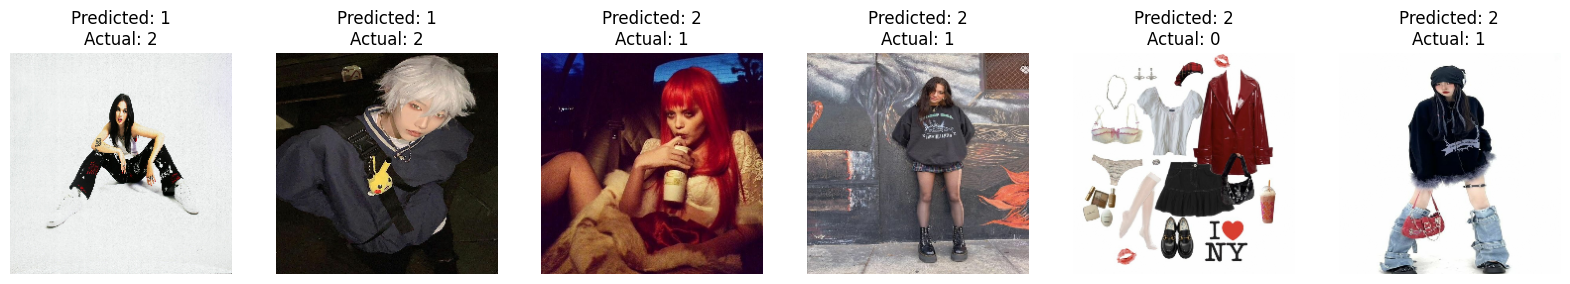

In [ ]:
# 0 : coquette :: 1 : grunge :: 2 : y2k
fig, ax = plt.subplots(1, len(x_wrong), figsize = (20, 20))
for i in range(len(x_wrong)):
    ax[i].imshow(x_wrong[i])
    ax[i].title.set_text("Predicted: " + str(y_wrong[i]) + "\nActual: " + str(actual[i]))
    ax[i].axis('off')
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.95      0.93      0.94        40
           2       0.91      0.95      0.93        41

    accuracy                           0.95       128
   macro avg       0.95      0.95      0.95       128
weighted avg       0.95      0.95      0.95       128



In [ ]:
print(confusion_matrix(y_true, y_pred, normalize = "true"))
print(confusion_matrix(y_true, y_pred))

[[0.9787234  0.         0.0212766 ]
 [0.         0.925      0.075     ]
 [0.         0.04878049 0.95121951]]
[[46  0  1]
 [ 0 37  3]
 [ 0  2 39]]


In [69]:
model.load_weights("weights/weights.03-0.37.h5")
model.evaluate(test, batch_size=32)

4/4 [==============================] - 7s 708ms/step - loss: 0.5445 - categorical_accuracy: 0.7578


[0.5444759130477905, 0.7578125]

In [70]:
model.load_weights("weights/weights.30-0.15.h5")
model.evaluate(test, batch_size=32)

4/4 [==============================] - 7s 730ms/step - loss: 0.2057 - categorical_accuracy: 0.9219


[0.2056528478860855, 0.921875]

In [74]:
model.load_weights("weights/weights.12-0.10.h5")
model.evaluate(test, batch_size=32)

4/4 [==============================] - 7s 696ms/step - loss: 0.0481 - categorical_accuracy: 0.9922


[0.04814916104078293, 0.9921875]

In [75]:
model.save("model.h5")